## 🧪 TikTok Creative Automation Agent (Design)

### **Author:** Santiago Velasco  
**Date:** June 2025  
**Tools:** Python (pandas), GPT-4

---

## 📌 Objective

This notebook's goal is to simulate a real growth + AI automation challenge using anonymized TikTok ad data.

---

## 🧭 Task Overview

- Analyze anonymized TikTok ad performance data
- Design a custom scoring formula to rank creatives
- Match top creatives with their TikTok videos
- Use GPT-4 to generate 3 new creative ideas
- Design an automation pipeline (MCP-style) that runs this weekly

---

## 📊 Part 1 — Ranking Formula

We design a custom formula to evaluate creative performance. The aim is to balance reach, engagement, and efficiency.

**Initial Formula**

We start with this initial scoring idea:

_score = a * CTR + b * conversions + c * views_50 - d * CPC_

Weights (`a`, `b`, `c`, `d`) will be tuned based on data exploration and business reasoning.

---

###  Data Exploration & Cleaning

Let’s start by loading and inspecting the dataset to understand available fields, detect missing values, and prepare it for analysis.

In [62]:
# imports
import pandas as pd
import numpy as np

# load the dataset
df = pd.read_csv("Anonymized_Ad_Performance.csv")
print("Shape:", df.shape)
df.head()

Shape: (13797, 14)


,Ad name,Text,By Day,Cost,CPC (destination),CPM,Impressions,Clicks (destination),CTR (destination),Reach,"Cost per 1,000 people reached",Video views at 25%,Video views at 50%,Conversions
0,stunt 2,"📢 ¡Atención, CDMX! $5000 YA están escondidos e...",2025-03-13,2471.4888,0.000000,73.202403,33762.40,0.00,0.000000,18868.85,130.982482,7409.6,6152.50,0.0
1,Qué harías 4 (target),🫰 ¿Qué harías con un préstamo de $750? 🫰,2025-02-19,2221.1552,3.582971,13.104185,169499.68,619.92,0.003657,95041.05,23.370483,22358.6,9794.55,108.6
2,Gimnasio,¡Beloz es tu mejor aliado financiero! Tu prime...,2025-02-18,2057.7040,5.085271,17.063264,120592.64,404.64,0.003355,68209.05,30.167610,29860.6,12526.95,74.4
3,señora gorro rosa,0,2025-02-23,1661.2992,7.210500,10.377029,160093.92,230.40,0.001439,88667.15,18.736355,15237.2,5147.40,34.8
4,señora gorro rosa,0,2025-02-27,1638.4280,8.752286,18.316937,89448.80,187.20,0.002093,49142.60,33.340279,7274.3,2942.85,35.4


In [2]:
df.tail()

,Ad name,Text,By Day,Cost,CPC (destination),CPM,Impressions,Clicks (destination),CTR (destination),Reach,"Cost per 1,000 people reached",Video views at 25%,Video views at 50%,Conversions
13792,stunt 1,"¡Atención, CDMX! 🎯 Vamos a esconder $5000 en a...",2025-04-04,0.0000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.0,0.00,0.0
13793,buen fin 3,Se viene el buen fin! 💛,2025-02-06,0.0000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.0,0.00,0.0
13794,labial y comida,"Beloz, tu mejor aliado financiero. ¡Solicita t...",2025-01-29,0.0000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.0,0.00,0.0
13795,verdulero,¿Y tú ya hiciste la despensa? #Beloz,2024-12-28,0.0000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.0,0.00,0.0
13796,Total of 13796 results,-,-,656851.6768,4.041796,10.004742,65654031.52,162514.8,0.002475,5649047.3,116.27654,3990158.7,1635183.85,24836.4


In [3]:
# We are going to do some common cleaning tasks into the data before starting with the normalization

df['By Day'] = pd.to_datetime(df['By Day'], errors='coerce')
df_clean = df.iloc[:-1].copy()

cols_numeric = [
    'Cost', 'CPC (destination)', 'CPM', 'Impressions', 'Clicks (destination)',
    'CTR (destination)', 'Reach', 'Cost per 1,000 people reached',
    'Video views at 25%', 'Video views at 50%', 'Conversions'
]

for col in cols_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean = df_clean[
    (df_clean['Impressions'] > 0) &
    (df_clean['Clicks (destination)'] > 0) 
]

df_clean = df_clean[(df_clean['Video views at 25%']<df_clean['Video views at 50%'])==False]

df_valid = df_clean.copy()
df_valid.describe()



,By Day,Cost,CPC (destination),CPM,Impressions,Clicks (destination),CTR (destination),Reach,"Cost per 1,000 people reached",Video views at 25%,Video views at 50%,Conversions
count,5985,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000
mean,2024-11-22 12:25:51.879699456,105.588461,4.725239,13.832314,10849.207392,27.142015,0.005117,6065.181061,24.885037,657.680167,269.119599,4.138546
min,2024-06-23 00:00:00,0.000000,0.000000,0.000000,1.120000,0.720000,0.000028,0.650000,0.000000,0.000000,0.000000,0.000000
25%,2024-09-23 00:00:00,9.248800,2.640000,8.464369,667.520000,2.160000,0.001701,370.500000,15.153019,45.100000,18.400000,0.000000
50%,2024-11-25 00:00:00,50.758400,3.712063,13.519302,3338.720000,11.520000,0.003759,1866.800000,24.286433,129.800000,52.900000,0.600000
75%,2025-01-10 00:00:00,129.351200,5.381852,18.276590,15221.920000,29.520000,0.005809,8517.600000,32.934714,567.600000,221.950000,4.200000
max,2025-06-22 00:00:00,2221.155200,625.631111,53.393844,169499.680000,730.080000,0.642857,95041.050000,97.954751,29860.600000,12526.950000,122.400000
std,NaN,168.268674,12.037602,7.342726,16375.875794,45.149026,0.014360,9148.666234,13.279889,1467.043027,662.417345,8.361676


### Data Cleaning Summary

Before analyzing creative performance, we applied a series of data cleaning steps to ensure the dataset was reliable and accurate:

1. **Converted date strings to datetime objects** using `pd.to_datetime()` for consistent time handling.

2. **Removed the last row**, which contained total aggregates and no valid ad data.

3. **Converted key numeric fields** (e.g., impressions, conversions, CTR) from strings to numeric types using `pd.to_numeric()`.

4. **Filtered out invalid rows**:
   - Only kept entries where:
     - `Impressions > 0`
     - `Clicks > 0`
   - This ensured we only analyzed ads that were actually seen and interacted with.

5. **Corrected logical inconsistencies**:
   - Removed rows where `Video views at 50%` > `Video views at 25%`, which is not logically possible.

This cleaning process gave us a dataset of valid ad performances, suitable for accurate analysis and ranking.

### Scoring Logic & Aggregation

Now that we have a clean dataset with valid entries only, the next step is to analyze performance by computing a custom score for each creative. To do this, we will:

1. **Group similar creatives** by `Ad name` and `Text`:
   - Some ads were run on multiple days.
   - We'll select the best-performing instance for each creative based on the highest number of conversions.

2. **Normalize key performance metrics** using Min-Max scaling:
   - `CTR (destination)` — click-through rate
   - `Conversions` — final goal
   - `Video views at 50%` — viewer retention
   - `CPC (destination)` — cost per click (used as a penalty)

3. **Define a scoring formula** to rank creatives:
   We'll assign weights to each metric to reflect business priorities. The proposed formula is:

`Score = (0.4 * CTR_ + 0.35 * Conversions + 0.25 * Views 50% - 0.1 * CPC)`

- 0.40 · CTR — Click-Through Rate is the strongest indicator of creative appeal. A higher CTR suggests the ad is compelling and captures user attention effectively.
- 0.35 · Conversions — Conversion performance reflects tangible outcomes, such as purchases or sign-ups. While slightly less emphasized than CTR in this formula, it's a critical metric of overall success.
- 0.25 · Video views at 50% — The proportion of viewers reaching the 50% point in a video speaks to content engagement and creative quality. This weight reflects its supportive — but not central — role in the score.
- -0.10 · CPC — Cost per Click is included as a penalty to discourage inefficient spend. A higher CPC reduces the overall score to reflect lower cost-effectiveness.

*Note:*
These weights can be easily adjusted to match specific marketing goals:
- For conversion-driven campaigns, increase the weight of Conversions (b)
- For brand awareness, boost CTR (a) and Views50_norm (c)
- For cost optimization, raise the CPC penalty or highlight cost-efficiency metrics more heavily (d)


4. **Sort the creatives by score** and extract the Top 5 to identify which ads are performing best overall.

This scoring system will help us prioritize high-performing creatives for future campaigns and idea generation.



In [101]:
# grouping by 'Ad name' + 'Text' and staying with the best rows for each ad (by Conversions)
mejores_anuncios = df_valid.loc[
    df_valid.groupby(['Ad name', 'Text', 'By Day'])['Conversions'].idxmax()
].copy()

# Min-Max normalization
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

mejores_anuncios['norm_ctr'] = normalize(mejores_anuncios['CTR (destination)'])
mejores_anuncios['norm_conversions'] = normalize(mejores_anuncios['Conversions'])
mejores_anuncios['norm_views_50'] = normalize(mejores_anuncios['Video views at 50%'])
mejores_anuncios['norm_cpc'] = normalize(mejores_anuncios['CPC (destination)'])  # Penalización

a = 0.5  # CTR
b = 0.3  # Conversiones
c = 0.2  # Views al 50%
d = 0.1  # CPC (penalized)

# calculate Score
mejores_anuncios['Score'] = ((
    a * mejores_anuncios['norm_ctr'] +
    b * mejores_anuncios['norm_conversions'] +
    c * mejores_anuncios['norm_views_50'] -
    d * mejores_anuncios['norm_cpc']
)
)

# --- Paso 5: Ordenar y mostrar Top 5 anuncios
top5 = mejores_anuncios.sort_values(by='Score', ascending=False).head(5)

# --- Paso 6: Mostrar columnas clave
cols_to_show = [
    'Ad name', 'Text',
    'CTR (destination)', 'Conversions', 'Video views at 25%','Video views at 50%', 'CPC (destination)', 'Score'
]

top5[cols_to_show].head()

,Ad name,Text,CTR (destination),Conversions,Video views at 25%,Video views at 50%,CPC (destination),Score
8580,renta,Siempre puedes contar con Beloz.,0.642857,0.0,0.0,0.00,0.036667,0.499994
8608,consejos financieros,3 consejos financieros que deberías saber a tu...,0.642857,0.0,1.1,0.00,0.036667,0.499994
28,labial y comida,"Beloz, tu mejor aliado financiero. ¡Solicita t...",0.009086,122.4,18431.6,10483.40,1.408557,0.474193
1,Qué harías 4 (target),🫰 ¿Qué harías con un préstamo de $750? 🫰,0.003657,108.6,22358.6,9794.55,3.582971,0.424802
2,Gimnasio,¡Beloz es tu mejor aliado financiero! Tu prime...,0.003355,74.4,29860.6,12526.95,5.085271,0.384128


## 🔎 Part 2 — Manual Video Identification

Since the dataset did not include direct TikTok URLs or publication dates, and many video descriptions were reused across different uploads, we manually matched each Top 5 creative to the most likely video on the @belozmx TikTok account.

We used the following criteria:
- **Video content**: matching visuals, actors, or scenes tied to the ad description.
- **Engagement**: views, likes, and comments as supporting signals.
- **Text matching**: we ensured the video description matches exactly.

Some creative texts were reused in multiple videos across time. In those cases, we selected the most relevant or best-performing match based on qualitative analysis and using the context provided in the field `Ad name`.

Here are the final matches for the Top 5 ads:

| Rank | Ad Name           | Video Description (Text)        | TikTok Link                                                                 |
|------|-------------------|----------------------------------|------------------------------------------------------------------------------|
| 1    | renta | Siempre puedes contar con Beloz. | [Video 1](https://www.tiktok.com/@belozmx/video/7419055530246688018)        |
| 2    | consejos financieros | 3 consejos financieros que deberías saber a tus 20! | [Video 2](https://www.tiktok.com/@belozmx/video/7429013696837586182)        |
| 3    | labial y comida | Beloz, tu mejor aliado financiero. ¡Solicita tu primer crédito de $750.°° con 0% de interés! #Beloz #finanzas | [Video 3](https://www.tiktok.com/@belozmx/video/7345180382960045317)        |
| 4    | Qué harías 4 (target) | 🫰 ¿Qué harías con un préstamo de $750? 🫰 | [Video 4](https://www.tiktok.com/@belozmx/video/7307342146946878725)        |
| 5    | Gimnasio | ¡Beloz es tu mejor aliado financiero! Tu primer préstamo de 750 pesos SIN INTERESES🥳 | [Video 5](https://www.tiktok.com/@belozmx/video/7341432603033046277)        |


In [93]:
top5['Video Link'] = [
'https://www.tiktok.com/@belozmx/video/7419055530246688018',
'https://www.tiktok.com/@belozmx/video/7429013696837586182',
'https://www.tiktok.com/@belozmx/video/7345180382960045317',
'https://www.tiktok.com/@belozmx/video/7307342146946878725',
'https://www.tiktok.com/@belozmx/video/7341432603033046277'
]

"""
v=3
df.loc[df[df['Text']==top5['Text'].iloc[v]]['By Day'].idxmin(), ['Ad name', 'Text', 'By Day']] # encontrar el día en que se subió tal video del top
df[(df['Text']==top5['Text'].iloc[v])&(df['Ad name']==top5['Ad name'].iloc[v])]['Impressions'].sum()
df_clean[(df_clean['Text']==top5['Text'].iloc[v])].sort_values(by='By Day')
top5['Text'].iloc[v]
df[(df['Text']=='3 consejos financieros que deberías saber a tus 20! ') & (df['Ad name']=='consejos financieros')].sort_values(by='By Day')
"""

top5['Text'].iloc[4]

top5[['Ad name','Text','Video Link','Score']]


,Ad name,Text,Video Link,Score
8580,renta,Siempre puedes contar con Beloz.,https://www.tiktok.com/@belozmx/video/74190555...,0.499994
8608,consejos financieros,3 consejos financieros que deberías saber a tu...,https://www.tiktok.com/@belozmx/video/74290136...,0.499994
28,labial y comida,"Beloz, tu mejor aliado financiero. ¡Solicita t...",https://www.tiktok.com/@belozmx/video/73451803...,0.474193
1,Qué harías 4 (target),🫰 ¿Qué harías con un préstamo de $750? 🫰,https://www.tiktok.com/@belozmx/video/73073421...,0.424802
2,Gimnasio,¡Beloz es tu mejor aliado financiero! Tu prime...,https://www.tiktok.com/@belozmx/video/73414326...,0.384128



## 🤖 PART 3 — TikTok Creative Generation Using LLMs

In this section, we leverage insights from the top-performing TikTok creatives identified in Parts 1 and 2 to generate three new video ideas using a Large Language Model (LLM). The goal is to maintain Beloz’s tone and creative direction, while proposing new engaging content formats that could perform well on the platform.

We use GPT-4 (via ChatGPT, June 2025) to assist in ideation, combining prompt engineering with structured formatting logic to ensure the output is actionable and platform-relevant.

---

###  Model Used
**GPT-4**  
(ChatGPT, June 2025 version, accessed via OpenAI)

---

### Formatting Logic

Each TikTok idea was structured into the following components for clarity and consistency:

- **💡 Title**: A creative hook or engaging question
- **🎬 Outline**: A brief description of the scene or narrative
- **📈 Trend or Meme**: A current TikTok trend or cultural reference used for relevance
- **📝 Caption**: The proposed video caption to support engagement and reach


### Prompt used:
<div style="border:1px solid #ccc; padding:10px; border-radius:5px; ; color;000000">
You are a creative strategist for a TikTok ad campaign in Mexico.

The product is Beloz: a digital lending app for micro-business owners. It offers fast, interest-free first loans (MX$750) and builds user loyalty with benefits on renewals. The tone is casual, agile, and culturally relevant.

Here are 5 successful creative formats the brand has used:
1. Storytelling: a young woman forgets to pay rent, solves it with Beloz (punchline: “¡así de Beloz!”)
2. Educational: “3 financial tips for your 20s”, with notebook visuals and direct-to-camera style.
3. Street vox pop: women asked what they'd buy with 750 pesos (lipstick, snacks, blouses) + corrido tumbado outro.
4. Small business vox pop: merchant shares what he’d buy for his job.
5. Gym setting: what would you buy with 750 pesos? (Headphones)

Now, based on these references, generate **3 new TikTok ad ideas** for @belozmx:
- Include: **hook**, **script outline**, **relevant meme or trend (if applicable)**, and **text caption**.
- Each idea should be short, creative, and feasible to record casually in real-life settings.
- The tone should be light, fun, and relatable for young adults or microentrepreneurs in Mexico.
</div>

### Ideas:



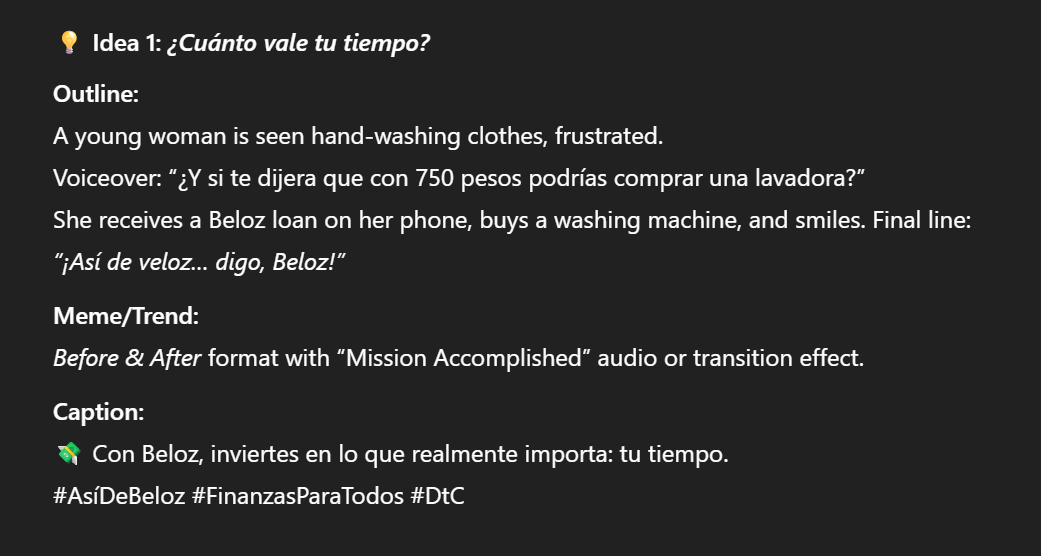

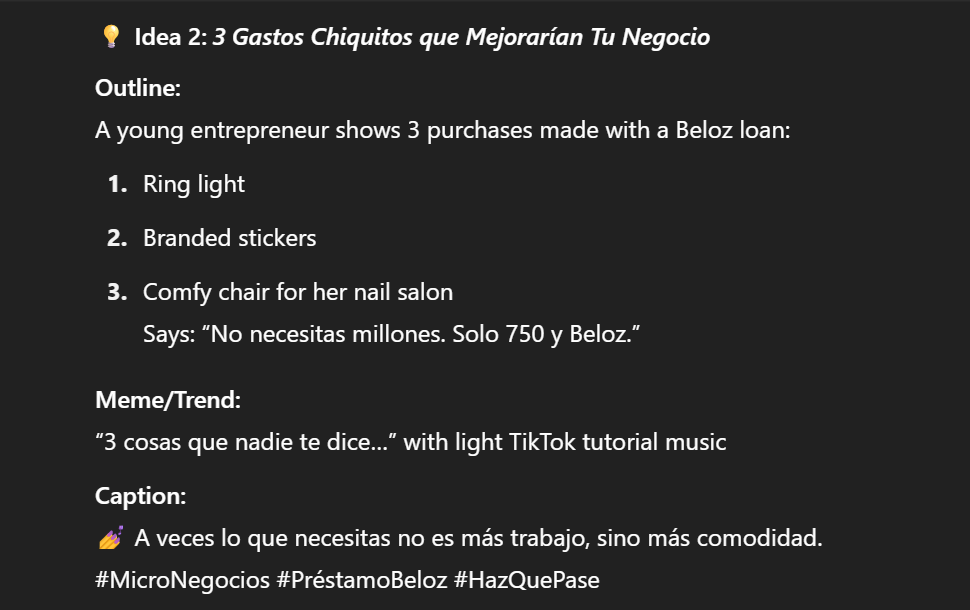

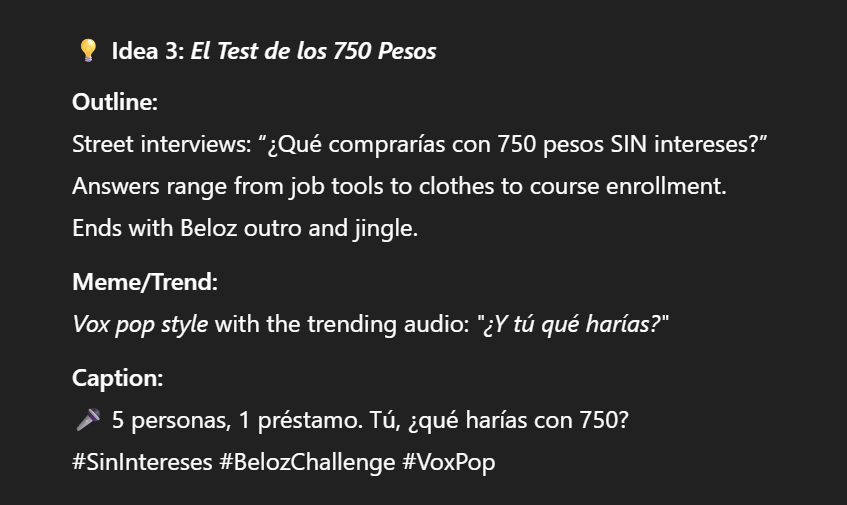

In [3]:
from IPython.display import Image, display

display(Image(filename='idea1.png'))
display(Image(filename='idea2.png'))
display(Image(filename='idea3.png'))



## 🤖 PART 4 – Weekly Automation Agent Design (MCP-style)

We design an AI-powered automation agent that replicates this creative analysis pipeline every week. The system should:
- Fetch the latest TikTok performance report via email.
- Clean, process, and score creatives.
- Identify top-performing ads and match them to existing videos.
- Use an LLM (GPT-4) to generate 3 new creative ideas.
- Email the final ideas automatically to the design team.

### 🔄 System Workflow
1. **Email Monitoring**: Listen for incoming emails with subject `"Weekly TikTok Report - {date}"`.
2. **CSV Download**: Extract and store the attached TikTok performance CSV.
3. **Data Cleaning**:
   - Remove total summary row.
   - Convert columns to numeric values.
   - Filter out invalid or empty records.
4. **Aggregate Data**: Group by `Ad name` + `Text` + `By Day` and compute averages for core metrics.
5. **Normalize Columns**: Apply Min-Max normalization to CTR, Conversions, Views, and CPC.
6. **Score Calculation**: Compute a performance score using a custom weighted formula.
7. **Top 5 Leaderboard**: Select the top 5 ranked creatives.
8. **Match TikToks**: Use the `Text` field to find matching videos from @belozmx.
9. **LLM Integration**: Feed insights into GPT-4 to generate 3 new TikTok ideas.
10. **Email Dispatch**: Send an executive-style email with the 3 proposals to `alejandro@amiloz.com`.


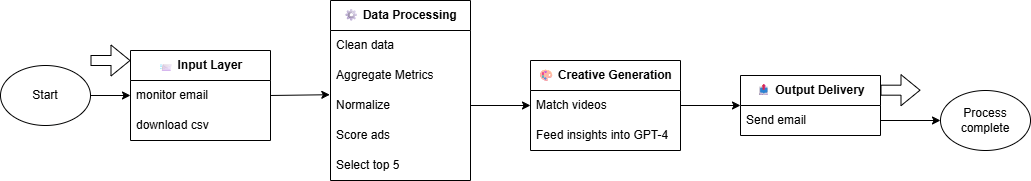

In [6]:
display(Image(filename='flowchart.png'))


### 📩 Sample Email Output (Sent by the Automation Agent)

<div style="border:1px solid #ccc; padding:10px; border-radius:5px; ; color;000000">

**To:** alejandro@amiloz.mx  

---

**Subject:** 🎯 New TikTok Creative Proposals – Weekly AI Report

---

Hola equipo de diseño,

Esta semana, el sistema automatizado de análisis creativo ha procesado el nuevo reporte de rendimiento de TikTok y ha generado 3 ideas originales utilizando un modelo de lenguaje avanzado (GPT-4), basadas en los videos con mejor desempeño.

A continuación, las propuestas creativas:


**1. 💰 “¿Qué harías con $750 en 30 minutos?”**  
Un formato estilo vox pop en la calle, preguntando a transeúntes cómo aprovecharían un préstamo instantáneo sin intereses.  
_Tendencia:_ formatos de entrevista rápida + hashtag #AsiDeVeloz  
📌 Caption: “Con Beloz, tu crédito llega antes que el antojo. 🚀 #Beloz #FinanzasFaciles”

**2. 💡 “Consejos que me salvaron los fines de quincena”**  
Un video estilo selfie, donde una joven comparte tips financieros útiles que culminan con usar Beloz como salvavidas.  
_Tendencia:_ educación financiera + corte casual  
📌 Caption: “Esto me hubiera gustado saber a los 20... #FinTips #BelozAliado”

**3. 🧃 “¿Crédito para vender más?”**  
Comerciante explica cómo usó un préstamo para reabastecer mercancía y crecer su negocio. Grabado en su local.  
_Tendencia:_ contenido de emprendedores reales  
📌 Caption: “Lo que nadie te dice de emprender con poco capital. 💼 #HistoriasBeloz”


**Referencias más efectivas (Top 5 esta semana):**  
1. [Siempre puedes contar con Beloz](https://www.tiktok.com/@belozmx/video/7419055530246688018)  
2. [3 consejos financieros que deberías saber a tus 20](https://www.tiktok.com/@belozmx/video/7429013696837586182)  
3. [Tu crédito de $750 sin interés](https://www.tiktok.com/@belozmx/video/7345180382960045317)  
4. [¿Qué harías con un préstamo de $750?](https://www.tiktok.com/@belozmx/video/7307342146946878725)  
5. [¡Beloz es tu mejor aliado financiero!](https://www.tiktok.com/@belozmx/video/7341432603033046277)


Saludos,  
**Beloz AI Creative Agent** 🤖
</div>


## 🎁 Bonus Analysis – Max vs. Mean Aggregation Methods

In our main analysis, we ranked each TikTok creative by selecting **the best-performing day** for each ad, based on the highest number of conversions. However, to ensure robustness and explore alternative evaluation criteria, we conducted a **secondary scoring strategy**: using the **mean performance across all available dates** for each ad.

---

### 📌 Method 1: Max-Based Scoring (Primary)
We grouped the dataset by `Ad name` and `Text`, and selected **the row with the highest number of conversions** per creative. This approach prioritizes the best possible scenario for each ad, highlighting its **peak performance** potential.

**Pros:**
- Ideal to detect what each ad is *capable of* under the best conditions.
- Useful when the focus is on discovering standout content.

**Cons:**
- Ignores underperformance or inconsistency.
- May overrepresent one-off success.

---

### 📌 Method 2: Mean-Based Scoring (Bonus)
Here, we grouped the same creatives and calculated the **average** of each scoring metric across all available days:
- `CTR (destination)`
- `Conversions`
- `Views at 50%`
- `CPC (destination)`

We then applied the same normalization and weighting formula as before.

**Pros:**
- Reflects **overall consistency** of performance.
- Better for understanding general behavior over time.

**Cons:**
- May dilute the strength of ads that performed extremely well on certain days.
- Sensitive to outliers or periods of low traffic.

---

Both methods have valid use cases depending on the goal:
- If your goal is **creative discovery** and iteration, *max-based* scoring highlights top-performing ideas worth replicating or evolving.
- If your focus is **long-term campaign stability**, *mean-based* scoring reveals which creatives maintain reliable performance over time.

In this challenge, we kept the max-based method as the primary approach, but we include this mean-based version as an additional insight to showcase analytical depth and flexibility.


In [105]:
grouped_mean = mejores_anuncios.copy()
grouped_mean = df_valid.groupby(['Ad name', 'Text']).agg({
    'CTR (destination)': 'mean',
    'Conversions': 'mean',
    'Video views at 50%': 'mean',
    'CPC (destination)': 'mean'
}).reset_index()

def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

grouped_mean['norm_ctr'] = normalize(grouped_mean['CTR (destination)'])
grouped_mean['norm_conversions'] = normalize(grouped_mean['Conversions'])
grouped_mean['norm_views_50'] = normalize(grouped_mean['Video views at 50%'])
grouped_mean['norm_cpc'] = normalize(grouped_mean['CPC (destination)'])  # Penalized

a = 0.5  # CTR
b = 0.3  # Conversions
c = 0.2  # Views at 50%
d = 0.1  # CPC (penalización)

grouped_mean['Score'] = (
    a * grouped_mean['norm_ctr'] +
    b * grouped_mean['norm_conversions'] +
    c * grouped_mean['norm_views_50'] -
    d * grouped_mean['norm_cpc']
)
top5_avg = grouped_mean.sort_values(by='Score', ascending=False).head(5)

cols_to_show = [
    'Ad name', 'Text', 'CTR (destination)', 'Conversions',
    'Video views at 50%', 'CPC (destination)', 'Score'
]

top5_avg[cols_to_show]


,Ad name,Text,CTR (destination),Conversions,Video views at 50%,CPC (destination),Score
95,renta,Siempre puedes contar con Beloz.,0.047649,0.771429,8.444286,2.250183,0.506306
68,consejos financieros,3 consejos financieros que deberías saber a tu...,0.046390,0.037500,4.600000,12.552134,0.484700
4,Ad name2025-06-11 14:05:27,Pediste un préstamos pero estás en buró? #fin...,0.007469,35.940000,397.555000,2.278911,0.387245
61,compra joyas,Todo lo que puedes llevarte por $750! #BelozPl...,0.035714,0.000000,0.000000,0.647778,0.374652
83,labial y comida,"Beloz, tu mejor aliado financiero. ¡Solicita t...",0.004217,28.579275,2374.994301,3.486691,0.339128


After applying both aggregation methods — one based on each ad's **best daily performance** and another based on its **average metrics across all available days** — we observed that **3 out of the original Top 5 creatives** still appear in the new Top 5 generated using mean-based scoring.


These recurring creatives demonstrate not only **high peak performance**, but also **strong and consistent performance over time**.
Their continued presence in both rankings validates them as **reliably engaging** and **effective**, not just one-time successes.
This overlap suggests that these ads are **excellent templates** for generating new creative ideas or iterations.


Using both scoring methods gives a **more complete picture** of ad performance:
- The **Max approach** helps us spot standout creative concepts.
- The **Mean approach** ensures those concepts are not outliers but actually
